# COMP 562 Final Project


# Fake News Classification Using Naive Bayes, Logistics Regrassion, and Random Forest

# I. Data Import & Exploration

In [33]:
# Import required libraries
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import pylab as pl
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [7]:
# Check working directory
os.getcwd()

'/content'

Read in data from CSV file and drop unnecessary column(s). Then, check for NAN values and whether the dataset is balanced.

In [10]:
# Read in data frame
df = pd.read_csv('fake_or_real_news.csv')
# We don't need the first column(number), so we keep the other columns
df = df[['title', 'text', 'label']]
# View the first few rows of data
df.head()

,title,text,label
0,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [11]:
# Check dimensions of dataset
df.shape

(6335, 3)

In [12]:
# Check if there are NAN values in the dataset
df.isnull().values.any()

False

([<matplotlib.patches.Wedge at 0x7f253b3b4690>,
 [Text(-0.0019265736658114806, 1.1099983280680699, 'REAL'),
  Text(0.001926573665811098, -1.1099983280680699, 'FAKE')],
 [Text(-0.0010587476902207235, 0.6099990811905608, '50.06%'),
  Text(0.0010587476902205132, -0.6099990811905608, '49.94%')])

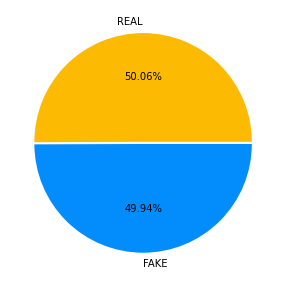

In [13]:
# There is no NAN in out dataset, we go ahead and check if the dataset is balanced
plt.figure(figsize=(5, 5))
colors = ['#FCBA03', '#038CFC']
# Plot a pie chart to clearly view the ratio between REAL and FAKE labels
plt.pie(df['label'].value_counts(), labels=['REAL', 'FAKE'], autopct='%.2f%%', explode=[0.01,0.01], colors=colors)

It is reasonable to conclude that the dataset is balanced based on the pie chart.

In adition, we could also generate word maps to visualize the most common words in both fake news and real news

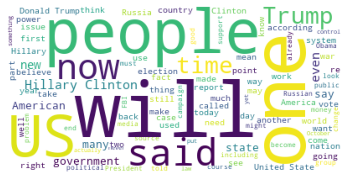

In [16]:
# Word cloud for fake news
words = " ".join(text for text in df[df.label=='FAKE'].text.astype(str))
wordcloud = WordCloud(stopwords=STOPWORDS, background_color ='white', max_words=100).generate(words)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

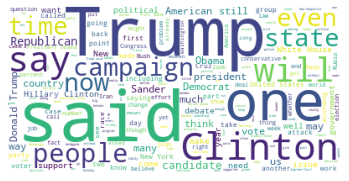

In [18]:
# Word cloud for real news
words = " ".join(text for text in df[df.label=='REAL'].text.astype(str))
wordcloud = WordCloud(stopwords=STOPWORDS, background_color ='white').generate(words)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## II. Data Processing

To better train our model, we need to process our data. Since our data source is text, it main contain punctuations and other special characters that main increase the difficulty for our model training, so we need to cope with that. Also, we need to lemmatize our text to transform words into their base forms(i.e. dogs -> dog; sleeping ->sleep) before moving on to model training

In [14]:
stop_words = set(stopwords.words('english'))

def data_cleaning(text):
    # Convert text to lower case
    text = text.lower()
    # Remove numbers, special characters, and punctuation from the text
    text = re.sub('[^a-zA-Z]', ' ', text)
    lemmatizer = WordNetLemmatizer()
    # Split text into tokens
    token = nltk.word_tokenize(text)
    lemmatized = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in token if word not in stop_words]
    cleaned_text = ' '.join(lemmatized)
    return cleaned_text

# Noticing that simply lemmatizing with WordNet doesn't do a good job on verbs, the helper function below helps
# get the tag of a single word recognized by WordNet, which can be fed to the lemmatizer to generate more accurate
# lemmatization
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

df['cleaned_text'] = df['text'].apply(data_cleaning)
df.head()

,title,text,label,cleaned_text
0,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,daniel greenfield shillman journalism fellow f...
1,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,google pinterest digg linkedin reddit stumbleu...
2,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,u secretary state john f kerry say monday stop...
3,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,kaydee king kaydeeking november lesson tonight...
4,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL,primary day new york front runner hillary clin...


In [15]:
# Print the shape to confirm that we have added an additional column to the dataset
df.shape

(6335, 4)

Checking the first rows and the shape of the dataset above, the data_cleaning function does add a column 'cleaned_text' which contains the desired text data. Thus we can move on to model training

# III. Model Training

To apply Naive Bayes, we first divide data into training set and testing set, and then construct the model using pre defined MultinomialNB model from sklearn

In [40]:
# Split dataset into training and testing with a ratio of 7:3
x_train, x_test, y_train, y_test = train_test_split(df['cleaned_text'], df['label'], test_size = 0.3)

              precision    recall  f1-score   support

        FAKE       0.92      0.91      0.92      2271
        REAL       0.91      0.91      0.91      2163

    accuracy                           0.91      4434
   macro avg       0.91      0.91      0.91      4434
weighted avg       0.91      0.91      0.91      4434



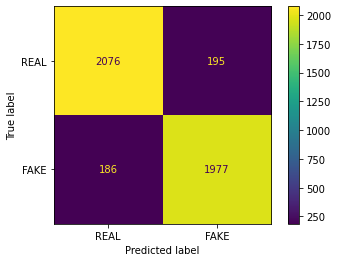

In [45]:
# Define the Naive Bayes model. Remove the words that appear in more than 90% of articles or less than 0.3% of articles
# since they are either not informative or may lead to overfitting
NaiveBayes = make_pipeline(TfidfVectorizer(min_df=0.003, max_df = 0.9), MultinomialNB())

NaiveBayes.fit(X=x_train, y=y_train)
y_pred_train = NaiveBayes.predict(x_train)
train_report = classification_report(y_train, y_pred_train)
# Print classification report for training set
print(train_report)
# Print the confusion matrix
cm = confusion_matrix(y_train, y_pred_train)
cmd = ConfusionMatrixDisplay(cm, display_labels=['REAL','FAKE'])
cmd.plot()

              precision    recall  f1-score   support

        FAKE       0.87      0.88      0.88       893
        REAL       0.89      0.88      0.89      1008

    accuracy                           0.88      1901
   macro avg       0.88      0.88      0.88      1901
weighted avg       0.88      0.88      0.88      1901



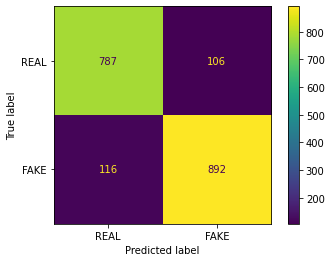

In [46]:
# Now apply the model on the testing set
y_pred_test = NaiveBayes.predict(x_test)
test_report = classification_report(y_test, y_pred_test)
print(test_report)
cm = confusion_matrix(y_test, y_pred_test)
cmd = ConfusionMatrixDisplay(cm, display_labels=['REAL','FAKE'])
cmd.plot()

              precision    recall  f1-score   support

        FAKE       0.94      0.96      0.95      2271
        REAL       0.96      0.94      0.95      2163

    accuracy                           0.95      4434
   macro avg       0.95      0.95      0.95      4434
weighted avg       0.95      0.95      0.95      4434



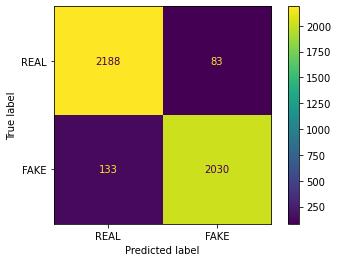

In [41]:
# Define the logistics regression model
lr = make_pipeline(TfidfVectorizer(min_df=0.003, max_df = 0.9), LogisticRegression())
lr.fit(x_train, y_train)
y_pred_train = lr.predict(x_train)
train_report = classification_report(y_train, y_pred_train)
# Print classification report for training set
print(train_report)
# Print the confusion matrix
cm = confusion_matrix(y_train, y_pred_train)
cmd = ConfusionMatrixDisplay(cm, display_labels=['REAL','FAKE'])
cmd.plot()

              precision    recall  f1-score   support

        FAKE       0.89      0.94      0.91       893
        REAL       0.94      0.89      0.92      1008

    accuracy                           0.91      1901
   macro avg       0.91      0.92      0.91      1901
weighted avg       0.92      0.91      0.91      1901



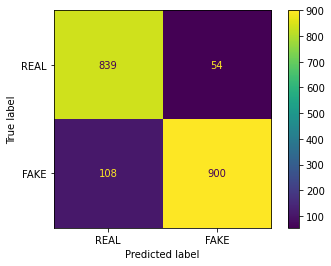

In [42]:
# Now apply the model on the testing set
y_pred_test = lr.predict(x_test)
test_report = classification_report(y_test, y_pred_test)
print(test_report)
cm = confusion_matrix(y_test, y_pred_test)
cmd = ConfusionMatrixDisplay(cm, display_labels=['REAL','FAKE'])
cmd.plot()

              precision    recall  f1-score   support

        FAKE       1.00      1.00      1.00      2271
        REAL       1.00      1.00      1.00      2163

    accuracy                           1.00      4434
   macro avg       1.00      1.00      1.00      4434
weighted avg       1.00      1.00      1.00      4434



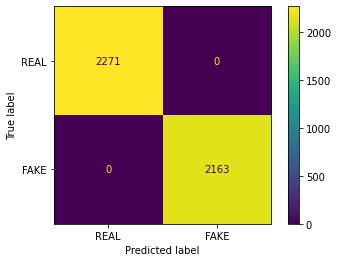

In [43]:
#
rf = make_pipeline(TfidfVectorizer(min_df=0.003, max_df = 0.9), RandomForestClassifier(n_estimators=150, max_depth=None, n_jobs=-1))
rf.fit(x_train, y_train)
y_pred_train = rf.predict(x_train)
train_report = classification_report(y_train, y_pred_train)
# Print classification report for training set
print(train_report)
# Print the confusion matrix
cm = confusion_matrix(y_train, y_pred_train)
cmd = ConfusionMatrixDisplay(cm, display_labels=['REAL','FAKE'])
cmd.plot()

              precision    recall  f1-score   support

        FAKE       0.87      0.92      0.90       893
        REAL       0.93      0.88      0.91      1008

    accuracy                           0.90      1901
   macro avg       0.90      0.90      0.90      1901
weighted avg       0.90      0.90      0.90      1901



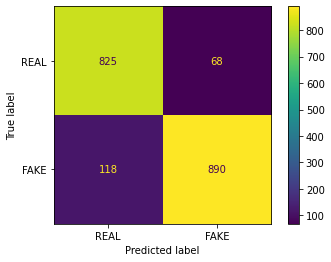

In [44]:
# Now apply the model on the testing set
y_pred_test = rf.predict(x_test)
test_report = classification_report(y_test, y_pred_test)
print(test_report)
cm = confusion_matrix(y_test, y_pred_test)
cmd = ConfusionMatrixDisplay(cm, display_labels=['REAL','FAKE'])
cmd.plot()